#### using bulit-in function of LibFMP library of Audiolabs, Erlangen for melody extraction from polyphonic audio. This was done before the deep learning experiments to get a rough idea on how much RPA can be obtained from polyphonic audio without learning involved.

In [3]:
## run this block only if you haven't installed these libraries
!pip install llvmlite==0.31.0
import llvmlite
!pip install librosa  
!pip install soundfile

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile

In [5]:
import importlib
moduleName = input('Enter name:') ## LibFMP without ''
importlib.import_module(moduleName)

## you can also do :
## import importlib
## importlib.import_module('LibFMP')

Enter name:LibFMP


<module 'LibFMP' from '/home/nbuser/library/LibFMP/__init__.py'>

In [6]:
import LibFMP

In [7]:
from LibFMP.C8.S2_Salience import compute_salience_rep as salience

In [8]:
wavfile = 'mir1k_16wavfiles/abjones_1_01.wav'
annotationfile = 'mir1k_16labels/abjones_1_01.pv'

In [9]:
x,sr = librosa.load(wavfile, mono=False)
mix = x[0,:]+x[1,:]

X = librosa.stft(mix) ## stft of total audio
print(X.shape)

X_left = librosa.stft(np.asfortranarray(x[0,:]))  ## stft of left channel (music only)
X_right = librosa.stft(np.asfortranarray(x[1,:])) ## stft of right channel (voice only)

print(X_left.shape)
print(X_right.shape)

(1025, 501)
(1025, 501)
(1025, 501)


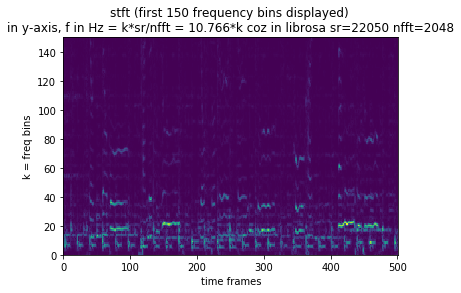

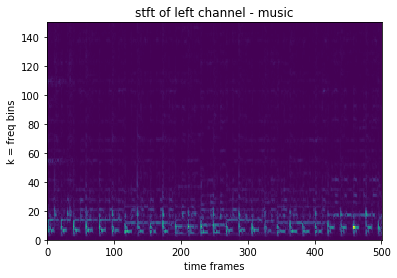

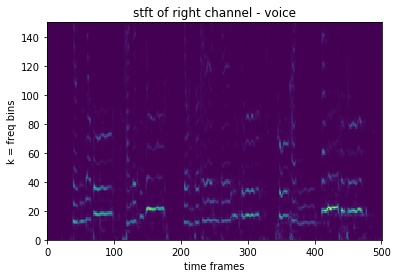

In [10]:
plt.pcolormesh(np.abs(X))
plt.ylim([0,150])
plt.title('stft (first 150 frequency bins displayed) \n'
          'in y-axis, f in Hz = k*sr/nfft = 10.766*k coz in librosa sr=22050 nfft=2048')
plt.ylabel('k = freq bins')
plt.xlabel('time frames')
plt.show()


plt.pcolormesh(np.abs(X_left))
plt.ylim([0,150])
plt.title('stft of left channel - music')
plt.ylabel('k = freq bins')
plt.xlabel('time frames')
plt.show()


plt.pcolormesh(np.abs(X_right))
plt.ylim([0,150])
plt.title('stft of right channel - voice')
plt.ylabel('k = freq bins')
plt.xlabel('time frames')
plt.show()

In [11]:
## by default in librosa, sr = 22050, nfft = 2048, win = 2048, hop = 512 
Z, F_coef_hertz, F_coef_cents = salience(mix,sr,N=2048, H=512, R=10, gamma=0, F_min=8.175799, F_max=1760)
## R = y-axis resolution in cents
## by default F_min = ref => 0 cents = 8.175799 hz => F_max = 1760 hz = 9300 cents 

print(Z.shape)  ## the salience representation, shape = (cents, timesteps) 
print(F_coef_cents.shape) ## must be (931,) as F_coef_cents = [0,10,20,30,....,9300] 
print(F_coef_hertz.shape) ## also (931,) bcoz its just the hz equivalent of F_coef_cents

(931, 501)
(931,)
(931,)


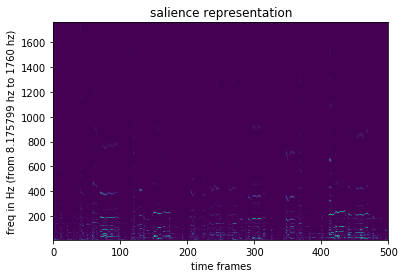

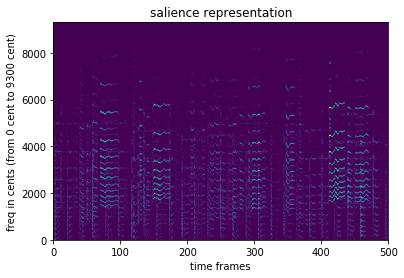

In [12]:
x_axis = np.arange(Z.shape[1])  ## np.arange(501)

plt.pcolormesh(x_axis,F_coef_hertz,Z)
plt.title('salience representation')
plt.ylabel('freq in Hz (from 8.175799 hz to 1760 hz)')
plt.xlabel('time frames')
plt.show() ## freq in hz vs time (salience rep)

plt.pcolormesh(x_axis,F_coef_cents,Z)
plt.title('salience representation')
plt.ylabel('freq in cents (from 0 cent to 9300 cent)')
plt.xlabel('time frames')
plt.show() ## freq in cents vs time (salience rep)

#### Next we use the built-in function of LibFMP library for melody extraction

In [13]:
from LibFMP.C8.S2_F0 import compute_traj_from_audio as F0_tracking
## full workflow of the function can be found here : 
## https://www.audiolabs-erlangen.de/resources/MIR/FMP/C8/C8S2_FundFreqTracking.html

In [14]:
traj, Z, T_coef, F_coef_hertz, F_coef_cents = F0_tracking(mix, N=882, H=441, R=10, F_min=8.175799, F_max=1760, gamma=0, tol=5)
## we set N=882, H=441 as per MIR1K annotation, so that no. of timeframes same as MIR1K annotation
## we keep F_min = 8.175799 => 8.175799 hz = 0 cents (this is also the same as MIR1K annotation)

## traj[] will have 2 columns
## 1st col stores the timesteps of different frames, 2nd col (traj[:,1]) will store the predicted melody
## V.V.IMP : traj[:,1] will be in hz not cents (property of F0_tracking() of LibFMP)

In [15]:
L = np.loadtxt(annotationfile) 
## annotation F0 values in semitone (with 8.175799 = 0 cent/semitone)

anno = L*100 ## convert annotation from semitone to cents

In [16]:
## even after using N=882, H=441 (MIR1K standards) still traj[:,1] may have few extra elements
## we need to consider only first N elements where N = len of anno

## also remember that anno is in cents but traj[:,1] is in hz
## we need to convert traj[:,1] from hz to cents

In [17]:
pred_melody = traj[0:len(anno)] 
pred_melody_cents = np.log2(pred_melody[:,1]/8.175799)*1200

print(anno.shape)
print(pred_melody_cents.shape)

(579,)
(579,)


#### next calculate the RPA

In [18]:
!pip install mir_eval

You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
from mir_eval.melody import raw_pitch_accuracy

In [20]:
voice_anno = np.empty(len(anno))
for i in range(len(anno)):
    if(anno[i]==0):
        voice_anno[i] = False
    else:
        voice_anno[i] = True
        
voice_pred = np.empty(len(pred_melody_cents))
for i in range(len(pred_melody_cents)):
    if(pred_melody_cents[i]==0):
        voice_pred[i] = False
    else:
        voice_pred[i] = True

RPA = raw_pitch_accuracy(voice_anno, anno, voice_pred, pred_melody_cents)
print('RPA = %.2f percent' %(RPA*100))

RPA = 41.24 percent


In [21]:
## RPA for polyphonic audio using F0_tracking() of LibFMP 
## this procedure was repeated for all 16 files in the dataset to get mean RPA 

## the results (RPA values) for all files can be found in the .txt file
## result for 'mir1k_16wavfiles/abjones_2_07.wav' have been omitted in the .txt file 
## It yielded very poor results hence discarded as an outlier